# **Stable Diffusion** 🎨
*...using `🧨diffusers`*

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

This Colab notebook shows how to use Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

Let's get started!

## 1. How to use `StableDiffusionPipeline`

Before diving into the theoretical aspects of how Stable Diffusion functions,
let's try it out a bit 🤗.

In this section, we show how you can run text to image inference in just a few lines of code!

### Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [1]:
!nvidia-smi

Mon Mar  4 22:58:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off | 00000000:01:00.0  On |                  N/A |
|  0%   35C    P8              16W / 285W |   1372MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [2]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.

We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [3]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

/home/liamo/Vscode/DeepLearning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
safety_checker/pytorch_model.fp16.safetensors not found
Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 471270.11it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Next, let's move the pipeline to GPU to have faster inference.

In [4]:
pipe = pipe.to("cuda")

And we are ready to generate images:

100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


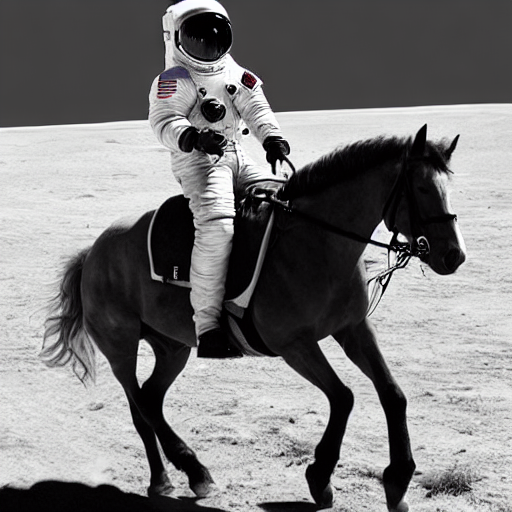

In [5]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
image.save(f"astronaut_rides_horse.png")

# or if you're in a google colab you can directly display it with
image

Running the above cell multiple times will give you a different image every time. If you want deterministic output you can pass a random seed to the pipeline. Every time you use the same seed you'll have the same image result.

100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


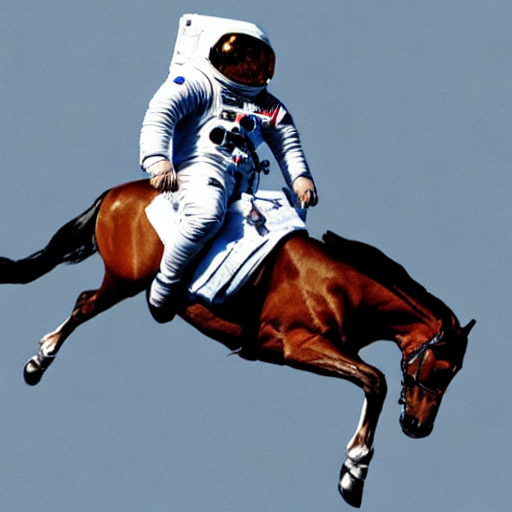

In [6]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, generator=generator).images[0]

image

You can change the number of inference steps using the `num_inference_steps` argument. In general, results are better the more steps you use. Stable Diffusion, being one of the latest models, works great with a relatively small number of steps, so we recommend to use the default of `50`. If you want faster results you can use a smaller number.

The following cell uses the same seed as before, but with fewer steps. Note how some details, such as the horse's head or the helmet, are less defin realistic and less defined than in the previous image:

100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


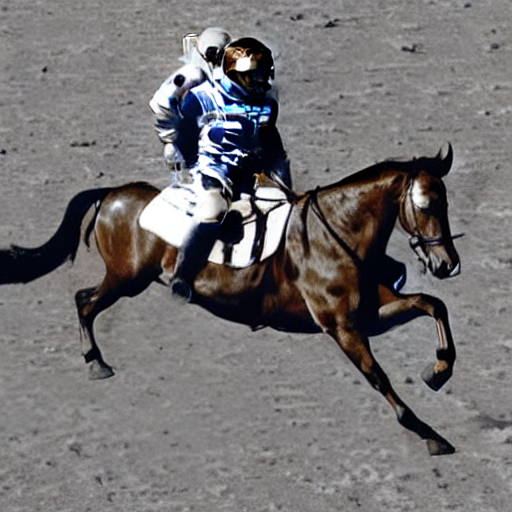

In [7]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]

image

The other parameter in the pipeline call is `guidance_scale`. It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. In simple terms classifier free guidance forces the generation to better match with the prompt. Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse.

To generate multiple images for the same prompt, we simply use a list with the same prompt repeated several times. We'll send the list to the pipeline instead of the string we used before.



Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done.

In [8]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Now, we can generate a grid image once having run the pipeline with a list of 3 prompts.

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


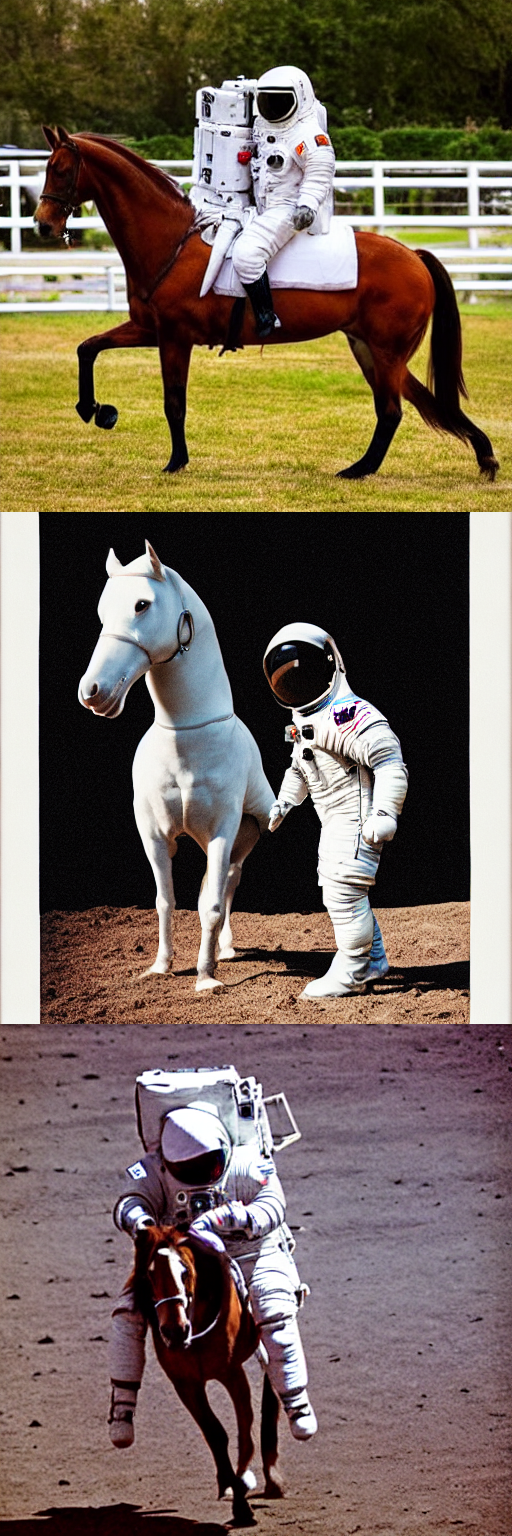

In [9]:
num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=3, cols=1)
grid

And here's how to generate a grid of `n × m` images.

In [10]:
num_cols = 3
num_rows = 4

prompt = ["a photograph of an astronaut riding a horse"] * num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

 90%|█████████ | 45/50 [00:08<00:00,  5.61it/s]

: 

### Generate non-square images

Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one.

100%|██████████| 50/50 [00:05<00:00,  8.42it/s]


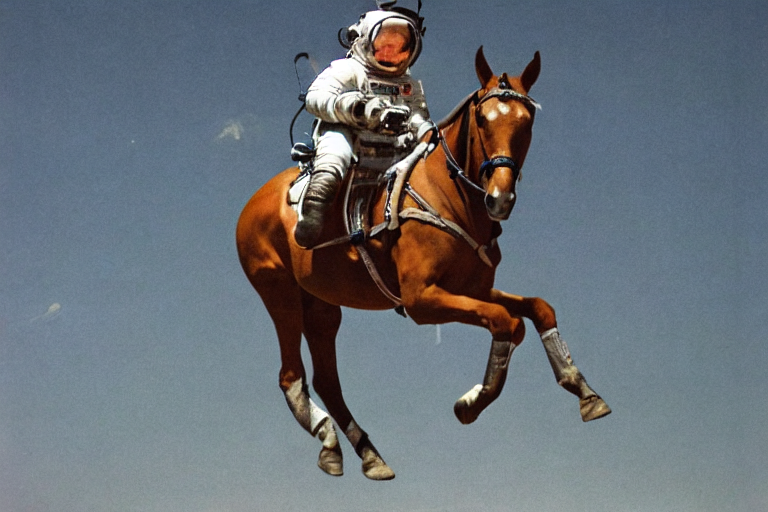

In [ ]:
prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt, height=512, width=768).images[0]
image

## 2. What is Stable Diffusion

Now, let's go into the theoretical part of Stable Diffusion 👩‍🎓.

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's see how to make advanced use of 🤗 Hugging Face Diffusers!

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components.

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch_device)

cuda


The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Now instead of loading the pre-defined scheduler, we'll use the K-LMS scheduler instead.

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

Next we move the models to the GPU.

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

We now define the parameters we'll use to generate images.

Note that `guidance_scale` is defined analog to the guidance weight `w` of equation (2) in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf). `guidance_scale == 1` corresponds to doing no classifier-free guidance. Here we set it to 7.5 as also done previously.

In contrast to the previous examples, we set `num_inference_steps` to 100 to get an even more defined image.

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise.

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

Cool $64 \times 64$ is expected. The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

The K-LMS scheduler needs to multiply the `latents` by its `sigma` values. Let's do this here

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

And finally, let's convert the image to PIL so we can display or save it.

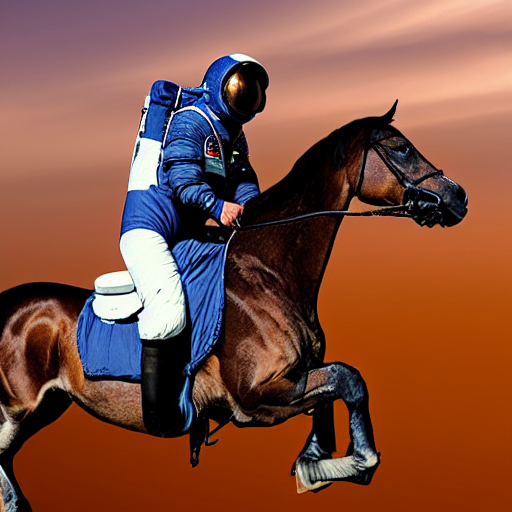

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

# CLIP

### What is CLIP and what does it do?

OpenAI has introduced a novel model known as CLIP, standing for Contrastive Language-Image Pre-training. This advanced model is adept at learning the relationships between entire sentences and the images they describe. Distinct from traditional models that are trained on single labels such as 'car' or 'dog', CLIP benefits from training with full sentences. This method significantly improves its ability to discern and understand the complex interplay between text and images, enabling it to accurately retrieve images that correspond to the provided text.

The core advantage of employing full sentences in training lies in the model's enhanced capacity to identify and learn from the nuanced connections between text and imagery. By assimilating a broader range of information, CLIP can uncover patterns and relationships that surpass simple object identification.

Moreover, when CLIP undergoes training with a large dataset comprising images and their respective texts, it showcases an additional capability: acting as an image classifier. Notably, the CLIP model, trained through this comprehensive strategy, outclasses state-of-the-art (SOTA) models on the ImageNet benchmark, including those specifically fine-tuned for image classification tasks alone.

Exploring the research paper will provide deeper insights into the CLIP model, its innovative training approach, and its remarkable achievements on benchmark datasets. This model marks a significant leap forward in the integration of full sentences into machine learning frameworks, paving the way for improved understanding and performance in model development.

Let's first to install necessary libraries

In [ ]:
!pip install timm
!pip install transformers

In [2]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

/tmp/ipykernel_23816/491664227.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tmp/ipykernel_23816/491664227.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Task1: Download the dataset from Kaggle
In this task, you need to download the dataset from Kaggle.
1. Install Kaggle python library (using kaggle package)
2. Set up your kaggle user name & kaggle api key into environment variable
  - Consider use `os.environ` to achieve this
  - Set username with `KAGGLE_USERNAME` system variable
  - Set kaggle api key with `KAGGLE_KEY` system variable
3. Download the `adityajn105/flickr8k` using `kaggle datasets download -d` command
4. Unzip downloaded zip

Optional: You can try 30k version by downloading `hsankesara/flickr-image-dataset`, nevertheless, you need to remember to change the `dataset` variable accordingly for the following pre-processing



- An example of where to find the username & key
![img](https://raw.githubusercontent.com/hqsiswiliam/COM3025_Torch/main/kaggle%20guidance.png)

In [ ]:
dataset = "8k"
# Your code here!

!pip install kaggle

os.environ['KAGGLE_USERNAME'] = 'lo00301'
os.environ['KAGGLE_KEY'] = '9d1f77162a035f7ef7b0ef3165c03cb8'
os.environ['URN'] = '6640106'

!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip

401 - Unauthorized - Unauthenticated
Archive:  flickr8k.zip
  inflating: Images/1000268201_693b08cb0e.jpg  
  inflating: Images/1001773457_577c3a7d70.jpg  
  inflating: Images/1002674143_1b742ab4b8.jpg  
  inflating: Images/1003163366_44323f5815.jpg  
  inflating: Images/1007129816_e794419615.jpg  
  inflating: Images/1007320043_627395c3d8.jpg  
  inflating: Images/1009434119_febe49276a.jpg  
  inflating: Images/1012212859_01547e3f17.jpg  
  inflating: Images/1015118661_980735411b.jpg  
  inflating: Images/1015584366_dfcec3c85a.jpg  
  inflating: Images/101654506_8eb26cfb60.jpg  
  inflating: Images/101669240_b2d3e7f17b.jpg  
  inflating: Images/1016887272_03199f49c4.jpg  
  inflating: Images/1019077836_6fc9b15408.jpg  
  inflating: Images/1019604187_d087bf9a5f.jpg  
  inflating: Images/1020651753_06077ec457.jpg  
  inflating: Images/1022454332_6af2c1449a.jpg  
  inflating: Images/1022454428_b6b660a67b.jpg  
  inflating: Images/1022975728_75515238d8.jpg  
  inflating: Images/102351840_

## Some pre-preocessing

In [3]:
import os 

captions_csv = "captions.csv"
caption_txt = "captions.txt"
Images = "Images/667626_18933d713e.jpg"

if os.path.isfile(captions_csv):
    print("captions csv already exists")
if os.path.isfile(caption_txt):
    print("caption txt already exists") 
if os.path.isfile(Images):
    print("image file already exists") 

df = pd.read_csv("./captions.txt")
df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
df.to_csv("captions.csv", index=False)

df = pd.read_csv("./captions.csv")
image_path = "Images"
captions_path = "Images"class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

df.head()

captions csv already exists
caption txt already exists
image file already exists


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  id  
0  A child in a pink dress is climbing up a set o...   0  
1              A girl going into a wooden building .   0  
2   A little girl climbing into a wooden playhouse .   0  
3  A little girl climbing the stairs to her playh...   0  
4  A little girl in a pink dress going into a woo...   0

## Config

Defining the configuration used in CLIP

In [4]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Utils

In [5]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

To prepare the text for encoding, sentences (also referred to as captions) must first be tokenized using the DistilBERT tokenizer. This process converts the sentences into a series of token ids (input_ids) and generates the necessary attention masks, which are then inputted into the DistilBERT model. As such, the dataset must also handle the tokenization process to ensure the texts are appropriately formatted for the encoder.

The dataset's code is provided below. Following this, a detailed explanation will be given to clarify the key operations performed within the code, ensuring a comprehensive understanding of the data preparation process for image and text encoding.

In the `__init__` method, a tokenizer object, specifically from the HuggingFace tokenizer suite, is passed as a parameter. This tokenizer is initialized upon running the model. It is used to pad and truncate the captions to a pre-defined maximum length, ensuring uniformity in data input sizes.

Within the `__getitem__` method, the procedure begins by loading an encoded caption, which comes in the form of a dictionary containing the keys input_ids and attention_mask. The values of this dictionary are then converted into tensors. Following this, the corresponding image is loaded, processed, and optionally augmented before being converted into a tensor. This image tensor is then stored in the dictionary under the key "image".

Finally, the original text of the caption is added to the dictionary with the key "caption". This inclusion is primarily for visualization purposes, allowing for easier interpretation and analysis of the data during the training and evaluation phases.

In [6]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The code for the image encoder is straightforward, utilizing the PyTorch Image Models (timm) library, which offers access to a wide range of image models from ResNets to EfficientNets, among others. In this instance, a ResNet50 model is selected as the image encoder. Alternatively, the torchvision library can also be used for employing ResNets without the need for installing an additional library.

The implemented code converts each image into a fixed-size vector, matching the size of the model's output channels. Specifically, for ResNet50, this results in a vector size of 2048. This transformation occurs after the application of the nn.AdaptiveAvgPool2d() layer, producing the final encoded output.

In [7]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

# Task2: Build the Text Encoder for CLIP using DistilBERT

Your task is to construct the text encoder component for the CLIP model, utilizing DistilBERT as the encoding framework. Similar to BERT, you will need to integrate two special tokens, CLS and SEP, at the beginning and end of your input text respectively. These tokens are crucial as they signify the start and end of a sentence.

Your primary objective is to capture the comprehensive meaning of a sentence, or caption, by using the final representation of the CLS token, as suggested by the DistilBERT and BERT literature. This approach mirrors the method applied to images, where they are transformed into fixed-size vectors.

In the context of DistilBERT (as well as BERT), the output hidden representation for each token, including the CLS token, is a vector of size 768. Therefore, your goal is to ensure that the entire caption is effectively encoded into the 768-sized representation of the CLS token, capturing the overall essence of the sentence.

In [8]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

Now that both images and texts have been encoded into fixed-size vectors (2048 for images and 768 for texts), the next step involves projecting them into a common space with **similar dimensions**. This adjustment is crucial for enabling the comparison of the two different types of data. By aligning them within the same dimensional space, it becomes possible to distinguish and separate non-relevant image-text pairs while associating those that are compatible. The forthcoming code segment will transform the 2048-dimensional image vectors and 768-dimensional text vectors into a unified 256-dimensional space (referred to as "projection_dim"), facilitating effective comparison.

In this context, "embedding_dim" denotes the size of the input vector (2048 for images and 768 for texts), while "projection_dim" refers to the size of the output vector, which, in this scenario, is set to 256. For a deeper understanding of this process, consulting the CLIP paper is recommended.

In [9]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## Combining CLIP

# Task3: Complete the CLIP Training Process

Your task is to complete the training process for the CLIP model by implementing the forward function within the CLIPModel class. This function is crucial for encoding images and texts, projecting them into a shared space, and computing the loss for model optimization.

Encode Images and Texts: Utilize the provided ImageEncoder and TextEncoder within the forward function to encode images and texts into fixed-size vectors. Note that these vectors will have different dimensionalities initially.

Project Encodings: Implement separate projection modules to transform the image and text encodings into a shared dimensional space, specifically into vectors of size 256. This step is necessary for comparing image and text representations effectively.

Compute the Loss: Calculate the loss based on the similarity between image and text vectors. This involves:

Calculating the dot product (using the @ operator in PyTorch) between image and text embeddings to obtain the logits matrix.
Transposing the necessary matrices to align dimensions for matrix multiplication.
Calculating the similarity scores within and between the groups of image and text embeddings.
Generating the targets matrix and calculating the cross-entropy loss between logits and targets.
Remember, the objective here is for the model to learn similar representations for corresponding images and texts, meaning that given either an image or its descriptive text, the model should produce matching 256-sized vectors for both.

You are encouraged to refer to the CLIP paper for a better understanding of the loss computation and its significance in the training process. Review the provided code snippets, focusing on the forward function, and complete it following the guidelines mentioned above. Ensure to check the shapes of the tensors at each step to confirm they align with the expected dimensions.

In [10]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    # Complete the forward operation
    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In an ideal situation, the text_embeddings and image_embeddings matrices would be identical, as they represent similar content. Now, let's ponder: if this were the case, how would the logits matrix appear? To understand this, consider the following simple example:

In [11]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In the ideal scenario, the 'logits' would transform into a matrix where, upon applying the softmax function, the diagonal elements are 1.0s, resembling an identity matrix, to use more technical terminology. The primary role of the loss function is to align the model's predictions closely with the target values. Therefore, this desired outcome is reflected in our target matrix. This is precisely why the code calculates the 'images_similarity' and 'texts_similarity' matrices, aiming to guide the model towards producing such an alignment between image and text representations.

## Train

Here are several functions designed to assist in loading training and validation data loaders, initializing our model, and then conducting training and evaluation. This section primarily consists of a straightforward training loop and essential utility functions.

In [12]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

This function is dedicated to training the model. It involves basic operations such as loading batches, passing them through the model, and updating the model parameters using the optimizer and learning rate scheduler.

In [13]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!). It can take some seconds before training actually starts because we are going to encode all the captions once in the train and valid dataset, so please don't stop it! Every thing is working fine.

In [14]:
torch.cuda.empty_cache()
main()

Epoch: 1


100%|██████████| 253/253 [00:11<00:00, 21.94it/s, valid_loss=2.15]


Saved Best Model!
Epoch: 2


100%|██████████| 253/253 [00:10<00:00, 23.30it/s, valid_loss=2.17]


Epoch: 3


100%|██████████| 253/253 [00:10<00:00, 23.76it/s, valid_loss=2.25]


Epoch: 4


100%|██████████| 253/253 [00:10<00:00, 23.35it/s, valid_loss=2.26]


## Inference

Training of the model is now complete. The next step involves performing inference, where we provide the model with a piece of text and request it to retrieve the most relevant images from an unseen validation (or test) dataset.

Task4: Complete the Function for Retrieving Image Embeddings:

Your task is to implement the function `get_image_embeddings` which involves loading the trained model, processing images from the validation set, and returning the image embeddings along with the model itself. Here are the steps you need to follow:

1. Initialize the DistilBertTokenizer with the pre-trained configuration specified in CFG.text_tokenizer.

2. Construct the validation data loader by passing the validation DataFrame, the initialized tokenizer, and the mode set to "valid" to the `build_loaders` function.

3. Load the CLIPModel onto the specified device from CFG.device and load the trained model weights from the specified model_path.

4. Set the model to evaluation mode to disable dropout and batch normalization layers during inference.

5. Initialize an empty list `valid_image_embeddings` to store the image embeddings generated by the model.

6. Iterate over the validation data loader, process each batch to obtain image embeddings, and append these embeddings to the `valid_image_embeddings` list. Ensure that no gradient calculations are performed during this process by using `torch.no_grad()` context.

7. Concatenate all the image embeddings collected in the list to form a single tensor.

The output should be the trained model and a tensor containing the image embeddings for the validation set, with the tensor having the shape (valid_set_size, 256).

In [15]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [16]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

100%|██████████| 253/253 [00:10<00:00, 24.27it/s]


# Task4: Implement the Function for Finding Matches

Your task is to complete a crucial part of the find_matches function, which showcases the primary capability of our model: retrieving the most relevant images from the validation set based on a text query.

We have completed the template for you. You need to generate the `text_embeddings` for similarity computation

In [17]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

## Test your function here.

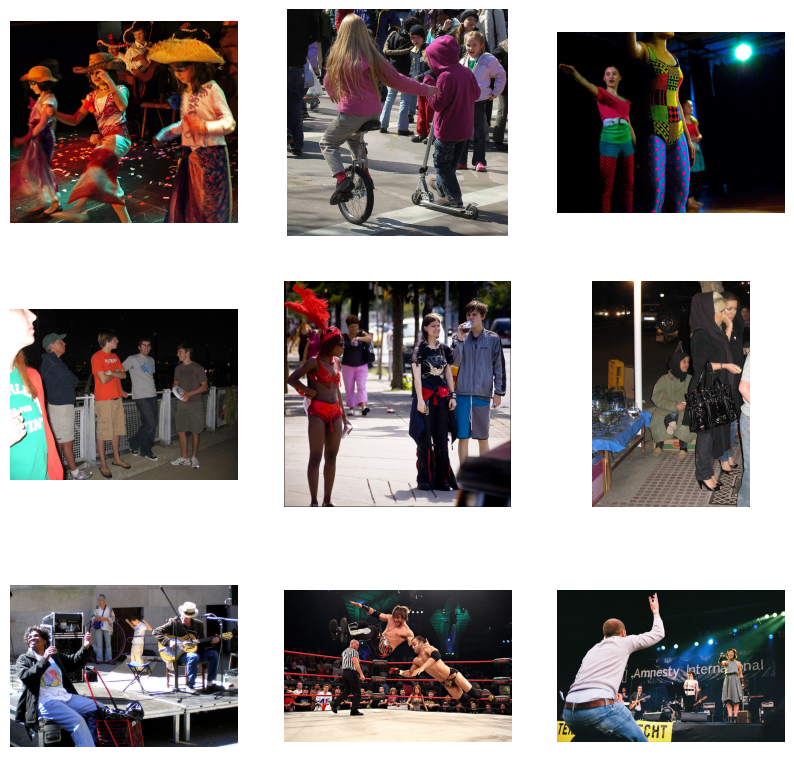

: 

In [21]:
find_matches(model,
             image_embeddings,
             query="dancing people",
             image_filenames=valid_df['image'].values,
             n=9)